### Preliminars


### **Introduction**

**GENERAL IDEA**
* Given a dataset of sales for a set of stores within a period, the idea is to train a model and make ind capable to do a forecast to predict a brand new period of sales. 

**PROCESS**
* Exploratory Data Analysis (EDA) is made to understand the information and execute some datawrangling
* Do a quick baseline (base models)
* tune models
* use ensemble methods to boost score

**INTERESTING FINDINGS**
* feature engineering is the most improtant  step in the compoetitio, so that this kind of relationships over the time around the represented event is the initial way to represent interactios in the model. Using time lags as a features was a key aspect in the process.
* ensemble methods to compose basic ones gives a better score
 - but `Simple averaging` worked better than Stacking.
 - This gave a higher score on Public Leaderboard and similar score on Private Leaderboard.
* We can improve this in any ways by adding different features from text data, ensembling from more models,...etc, but consumption of cmputationa resources aree higher


---
> `[*]` NOTE: I've run this notebook in google colab, so there are some specific teps if you are running it in this environment





#### [*] Colab Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive'
%cd 'My Drive/c_mintic-coursera.DS.05_Competitive.Apps/01_FinalProject/notebooks'
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/My Drive/c_mintic-coursera.DS.05_Competitive.Apps/01_FinalProject/notebooks
10_FinalProject_v1.ipynb  requirements.txt		    submissions
models			  submission_linear_regression.csv


#### [*] Requirements

In [0]:
#!pip install -r requirements.txt

#### Libraries Used

In [3]:
import numpy as np
import pandas as pd

#utils
import gc # garbage collection: drop temporal object
import os
import warnings
#
from itertools import product
from tqdm.notebook import tqdm # progress measure (from tqdm import tqdm, tqdm_notebook )
# plots
import matplotlib.pyplot as plt
import seaborn as sns

# models
import lightgbm as lgb
import sklearn
from sklearn import feature_extraction
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
import pickle # models.persist

# models.dl
import tensorflow as tf
import keras

# options
%matplotlib inline 
pd.set_option('display.max_rows', 640)
pd.set_option('display.max_columns', 50)
#
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')

# verify product versions
for p in [np, pd, sklearn, lgb]:
    print (p.__name__, p.__version__)
#print('pandas-version: %s' % (pd.__version__))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


numpy 1.18.5
pandas 1.0.4
sklearn 0.22.2.post1
lightgbm 2.2.3


Using TensorFlow backend.


#### Utility Functions

In [0]:
def downcast_dtypes(df):
    '''
        Change column type in the dataframe: 
        * `float64` -> `float32`
        * `int64`   -> `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

#### Explore Files

In [5]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/competitive-data-science-predict-future-sales/item_categories.csv
../input/competitive-data-science-predict-future-sales/items.csv.zip
../input/competitive-data-science-predict-future-sales/sales_train.csv.zip
../input/competitive-data-science-predict-future-sales/sample_submission.csv.zip
../input/competitive-data-science-predict-future-sales/shops.csv
../input/competitive-data-science-predict-future-sales/test.csv.zip


## Load Data

In [0]:
file_dir = "../input/competitive-data-science-predict-future-sales"

sales = pd.read_csv(file_dir + '/sales_train.csv.zip')
shops = pd.read_csv(file_dir + '/shops.csv')
items = pd.read_csv(file_dir + '/items.csv.zip')
item_cats = pd.read_csv(file_dir + '/item_categories.csv')
test_data =  pd.read_csv(file_dir + '/test.csv.zip')
#

In [0]:
# dir variables 
MODELS_DIR = 'models' #store trained model
PREDICTION_DIR = 'prediction' # do prediction
SUBMISSION_DIR = 'submissions' # submissions data

In [0]:
sample_submission = pd.read_csv(file_dir + '/sample_submission.csv.zip')

In [0]:
# sales.head(4)


In [0]:
#sales['date_dt'] =  pd.to_datetime(sales['date'], format='%d.%m.%Y', errors='ignore)

### Exploratory Data Analysis

#### Items per category

In [0]:
items_per_category = items.item_category_id.value_counts().iloc[:10]
items_per_category = items_per_category.sort_index(sort_remaining=True)

Text(0.5, 1.0, 'NumItems x category')

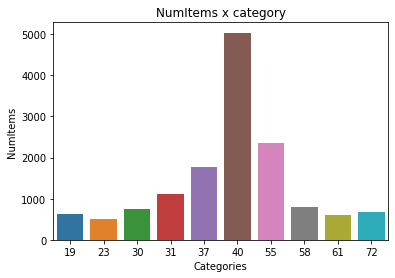

In [12]:
sns.barplot(items_per_category.index, items_per_category.values)
plt.xlabel("Categories")
plt.ylabel("NumItems")
plt.title("NumItems x category")

#### Top Shops
* based on item counts
* 31 is the shop that sold more items for the period of time

Text(0.5, 1.0, 'Top shops')

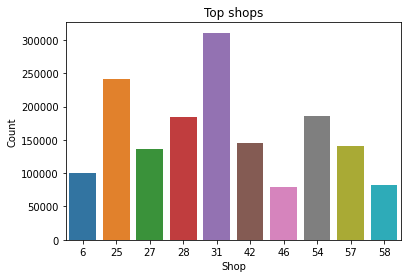

In [13]:
popular_shops = sales.groupby('shop_id')['item_cnt_day'].sum()
popular_shops = popular_shops.sort_values(ascending=False)[:10]



sns.barplot(popular_shops.index, popular_shops.values)
plt.xlabel("Shop")
plt.ylabel("Count")
plt.title("Top shops")


#### Top Items
* based on last 33months. 
* 20949 is most popular item for the time period

Text(0.5, 1.0, 'Top items')

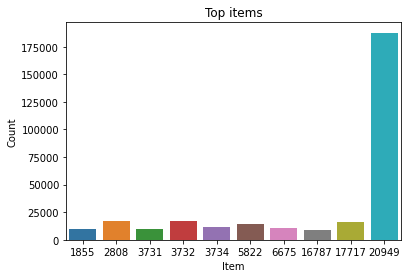

In [14]:
popular_items = sales.groupby('item_id')['item_cnt_day'].sum()
popular_items = popular_items.sort_values(ascending=False)[:10]

sns.barplot(popular_items.index, popular_items.values)
plt.xlabel("Item")
plt.ylabel("Count")
plt.title("Top items")

#### Items sold through time
* per month
* top on month 11
* decreasing trend of items sold

Text(0.5, 1.0, 'Items sold x month')

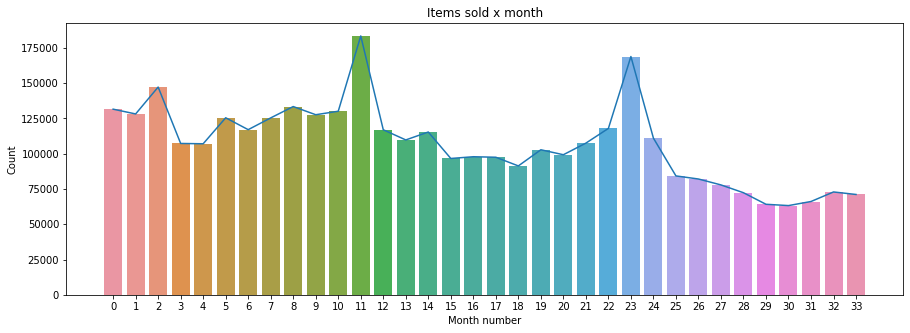

In [15]:
item_cnt_month = sales.groupby('date_block_num')['item_cnt_day'].sum()

plt.figure(figsize=(15,5))
sns.barplot(item_cnt_month.index, item_cnt_month.values)
plt.plot(item_cnt_month.index, item_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Items sold x month")

#### Sold x month

Text(0.5, 1.0, 'Total price of items sold in each month')

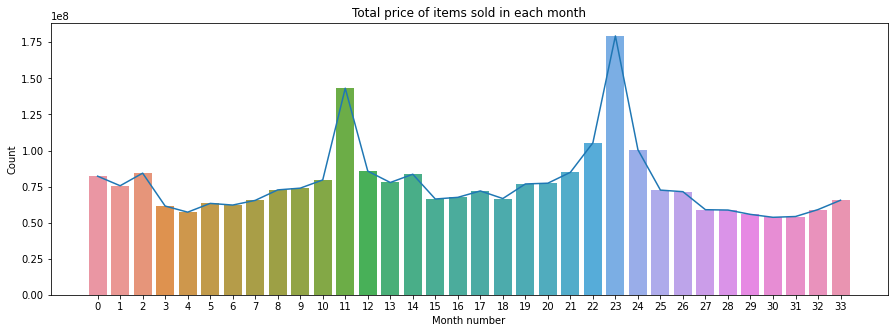

In [16]:
price_cnt_month = sales.groupby('date_block_num')['item_price'].sum()
plt.figure(figsize=(15,5))
sns.barplot(price_cnt_month.index, price_cnt_month.values)
plt.plot(price_cnt_month.index, price_cnt_month.values)
plt.xlabel("Month number")
plt.ylabel("Count")
plt.title("Total price of items sold in each month")

#### Correlation, <ItemsSold,Price> 
* 0.735

In [17]:
np.corrcoef(item_cnt_month.values, price_cnt_month.values)

array([[1.        , 0.73469191],
       [0.73469191, 1.        ]])

### Preprocessing

In [18]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


#### Testdata: add blocknum==34


In [19]:
test_block = sales['date_block_num'].max() + 1 # test_block = sales['date_block_num'].iloc[-1] + 1
test_data['date_block_num'] = test_block
test_data = test_data.drop(columns=['ID'])
test_data.head()

,shop_id,item_id,date_block_num
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


#### Build base dataset

* Grid to combine <shop,item,month>

In [0]:
# Creeate target grid with:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid = pd.concat([grid, test_data], sort=True)

* Add features grouping <shop,item,month>

In [0]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg( {'item_cnt_day':'sum'} ).rename(columns={'item_cnt_day':'target'}) # previous syntax: gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
# gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'target_shop'}) # previous syntax: gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
# gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'}).rename(columns={'item_cnt_day':'target_item'}) # previous syntax: gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
# gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();


In [22]:
all_data.head()

,date_block_num,item_id,shop_id,target,target_shop,target_item
0,0,22154,59,1.0,2017.0,18.0
1,0,2552,59,0.0,2017.0,0.0
2,0,2554,59,0.0,2017.0,1.0
3,0,2555,59,0.0,2017.0,2.0
4,0,2564,59,0.0,2017.0,5.0


* then create extra features using lags [1,2...12] months ago

In [23]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) #list(all_data.columns.difference(['ID'] + index_cols)) 
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift




* join features

In [0]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = ['target_item', 'target_shop', 'target', 'date_block_num']
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

# Category for each item
# <items_features (a),item_categoru_features,shop_features>
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

* information is stored in `all_data` object

In [25]:
all_data.head(4)

,date_block_num,item_id,shop_id,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,12,10297,54,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,2.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,12,10296,54,3.0,8198.0,17.0,0.0,24.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,12,10298,54,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,12,10300,54,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,53.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37


### Feature Extraction / Text
---

[disabled temporary beccause of memory restriction]

* Use some text features inside the dataset, i.e, length of item and number of words

In [26]:
'''
items.iloc[0:2]['item_name'].map(lambda x: len(str(x).split(' ')))
'''

"\nitems.iloc[0:2]['item_name'].map(lambda x: len(str(x).split(' ')))\n"

In [27]:
'''
#Text Features (a)
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
items['item_name_len'] = items['item_name'].map(len) #Lenth of Item Description
items['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
items.drop(columns='item_name', inplace=True)
items.head()
'''

"\n#Text Features (a)\nfeature_cnt = 25\ntfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)\nitems['item_name_len'] = items['item_name'].map(len) #Lenth of Item Description\nitems['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' '))) #Item Description Word Count\ntxtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())\ncols = txtFeatures.columns\nfor i in range(feature_cnt):\n    items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]\nitems.drop(columns='item_name', inplace=True)\nitems.head()\n"

In [28]:
'''
#Text Features (b)
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
item_cats['item_category_name_len'] = item_cats['item_category_name'].map(len)  #Lenth of Item Category Description
item_cats['item_category_name_wc'] = item_cats['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(item_cats['item_category_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    item_cats['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
item_cats.drop(columns='item_category_name', inplace=True)
item_cats.head()
'''

"\n#Text Features (b)\nfeature_cnt = 25\ntfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)\nitem_cats['item_category_name_len'] = item_cats['item_category_name'].map(len)  #Lenth of Item Category Description\nitem_cats['item_category_name_wc'] = item_cats['item_category_name'].map(lambda x: len(str(x).split(' '))) #Item Category Description Word Count\ntxtFeatures = pd.DataFrame(tfidf.fit_transform(item_cats['item_category_name']).toarray())\ncols = txtFeatures.columns\nfor i in range(feature_cnt):\n    item_cats['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]\nitem_cats.drop(columns='item_category_name', inplace=True)\nitem_cats.head()\n"

In [29]:
'''
#Text Features (c)
feature_cnt = 25
tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)
shops['shop_name_len'] = shops['shop_name'].map(len)  #Lenth of Shop Name
shops['shop_name_wc'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(feature_cnt):
    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
shops.drop(columns='shop_name', inplace=True)
shops.head()
'''

"\n#Text Features (c)\nfeature_cnt = 25\ntfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)\nshops['shop_name_len'] = shops['shop_name'].map(len)  #Lenth of Shop Name\nshops['shop_name_wc'] = shops['shop_name'].map(lambda x: len(str(x).split(' '))) #Shop Name Word Count\ntxtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())\ncols = txtFeatures.columns\nfor i in range(feature_cnt):\n    shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]\nshops.drop(columns='shop_name', inplace=True)\nshops.head()\n"

In [0]:
# all_data = downcast_dtypes(all_data)
# #Items features (a)
# all_data = pd.merge(all_data, items, how='left', on='item_id')
# #Item Category features
# all_data = pd.merge(all_data, item_cats, how='left', on='item_category_id')
# #Shops features
# all_data = pd.merge(all_data, shops, how='left', on='shop_id')
# all_data.head()

## Train/Test split

In [31]:
dates = all_data['date_block_num']

print('Test `date_block_num` is %d' % test_block)

Test `date_block_num` is 34


In [0]:
dates_train  = dates[dates <  test_block]
dates_test  = dates[dates == test_block]

X_train = all_data.loc[dates <  test_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == test_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  test_block, 'target'].values
y_test =  all_data.loc[dates == test_block, 'target'].values

#### Target range 
* just take [0..20]

In [33]:
target_range = [0, 20]
target_range

[0, 20]

In [34]:
y_train

array([ 4.,  3., 14., ...,  0.,  0.,  0.], dtype=float32)

## Models

### First LEvel
Taking inmid we've a time component, we will use schema type f. 
- we use first level model to build test meta-features (a)
- we use first level model to build 2-nd level tran meta-features (b

#### (a) Test Meta-features

* **Linear Regression** over numeric columns and get prediictions fot test month

In [0]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values).clip(*target_range)

  - > submission 

In [0]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lr})
submission.to_csv( SUBMISSION_DIR + '/submission_linear_regression.csv', index=False)

In [37]:
submission.head()

,ID,item_cnt_month
0,0,0.595136
1,1,0.101658
2,2,0.955156
3,3,0.234573
4,4,0.118508


* **LightGBM** then

In [0]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test).clip(*target_range)

* persist this model as picke (to not waste on run notebook again)

In [0]:
pkl_filename = MODELS_DIR +'/lgb_classifier.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

- > submission 

In [0]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_lgb})
submission.to_csv( SUBMISSION_DIR + '/submission_lgb.csv', index=False)
# !ls submissions

* Concatenate test predictions to get meta-features for test

In [0]:
X_test_level2 = np.c_[pred_lr, pred_lgb]

#### Train meta-features

then implement ** scheme f)** of reading material. Here, we will use duration T equal to month and M=15.

That is, we need to get predictions (meta-features) from linear regression and LightGBM for months [27-33]. Use the same parameters as in above models.

In [0]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32, 33])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin(dates_train_level2)]



* **kfold scheme in time series**: in time series task we have a fixed perido of time we asked to predict, so:
 - split trani data into chunks of duration T. select first M chunks
 - fit N diverse models on those M chunks to predict M+1 chunk. Then fit those models on frst M+1 chinks and predict for chunk M+2 and so on, until the end. After that use all train data to fit models and get predictions for test. Now we will have meta-features for the chunks starting from number M+1 as well as meta-features for the test. 
 - now we can use meta-features from first K chunks [M+1,M+2,...,M+K] to fit level 2 models and validate them on chunk M+K+1. Essentially we are back to step 1, with the lesser ampunt of chunks and meta-features instead of just features. 


In [45]:
# And here we create 2nd level feeature matrix, init it with zeros first# And he 
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Now fill `X_train_level2` with metafeatures
pbar = tqdm(dates_train_level2.unique())
for cur_block_num in pbar:
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           We can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    # print(cur_block_num)
    pbar.set_description('{}: Split'.format(cur_block_num))
    _X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    _X_test =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    _y_train = all_data.loc[dates <  cur_block_num, 'target'].values
    _y_test =  all_data.loc[dates == cur_block_num, 'target'].values
    
    pbar.set_description('{}: LR'.format(cur_block_num))
    lr.fit(_X_train.values, _y_train)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr.predict(_X_test.values).clip(*target_range)
    
    pbar.set_description('{}: LGB'.format(cur_block_num))
    model = lgb.train(lgb_params, lgb.Dataset(_X_train, label=_y_train), 100)
    X_train_level2[dates_train_level2 == cur_block_num, 1] = model.predict(_X_test).clip(*target_range)

 the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig scatter plot between the two metafeatures. Plot the scatter plot below.

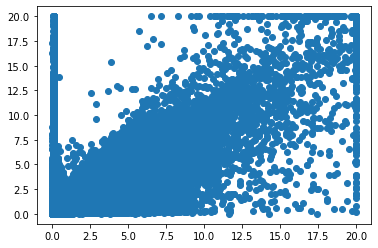

In [46]:
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1]);

### Ensembling

using linear convex mix: 
>$Mix = \alpha . linear + (1- \alpha ).light\_gbm$.
so we need to find optimal $\alpha$



In [47]:
alphas_to_try = np.linspace(0, 1, 1001)

r2_scores = np.array([r2_score(y_train_level2, np.dot(X_train_level2, [alpha, 1 - alpha])) for alpha in alphas_to_try])
best_alpha = alphas_to_try[r2_scores.argmax()]
r2_train_simple_mix = r2_scores.max()

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.084000; Corresponding r2 score on train: 0.082450


then compute predictions

In [0]:
pred_simple_averaging = best_alpha * pred_lr + (1 - best_alpha) * pred_lgb
#test['item_cnt_month'] = test_preds
#test[['ID', 'item_cnt_month']].to_csv('submission_averaging.csv', index=False)

> submission

In [0]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_simple_averaging})
submission.to_csv( SUBMISSION_DIR + '/submission_averaging.csv', index=False)

### Stacking

fit linear regressin to the metafeatures

In [50]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

compute R2 for train/test

In [0]:
pred_stacking = lr.predict(X_test_level2).clip(*target_range)
#train_preds = lr.predict(X_train_level2).clip(*target_range)
#r2_train_stacking = r2_score(y_train_level2, pred_stacking)
#print('Train R-squared for stacking is %f' % r2_train_stacking)

> submission

In [0]:
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': pred_stacking})
submission.to_csv( SUBMISSION_DIR + '/submission_stacking.csv', index=False)

In [0]:
test_preds_2 = lr.predict(np.vstack((pred_lr, pred_lgb)).T).clip(*target_range)
submission = pd.DataFrame({'ID': sample_submission.ID, 'item_cnt_month': test_preds_2})
submission.to_csv( SUBMISSION_DIR + '/submission_stacking2.csv', index=False)

# Annexes
### Course Structure
###### Topics
* udnerstand business problem, problem formalization
* data collection (in a competition, all data are collected)
* exploratory (eda)
* preprocess, feature generation
* modeling
  - models & validation: linear (logistic, svm) , tree-based (random-forest,gbdt), knn, deep-learning:neural-nets
  - metrics
  - model ensembling (xgboost)
  - hyper parameter
* deploy model
###### Libraries

* sklearn 
* keras, pytorch, tf

### Course Relevant Points
* tine series dataset / daily sales data 
* trainig-data: item sold x shop x day (daily)
* test-data: item sold x shop (aggregate sales: monthly sales)
* task: forecast the model for testing period
 6million
* predict daily sales ofr a period
### Submission Relevant Points
* step by step clear
* feature preprorocessing
* eda (observaciones intresantes)
* validation (train/test sliut)
* data leakages
* correct metric optimized
* apply: meand encodings
* apply: advanced features
* apply: hyper prametero tunning
* apply: ensembling

### Kaggle Relevant Points
* A3: Model Summary
  - include: training method, important features, tools used, tiempo de entrenamiento
* A4: Featurs Selection / Engineering
  - eda opartial plots de los features mas improtalntes o lista deellos
  - cómo se seleccionan features
  - si se hicieron transfofmaciones
  - si se usaron datos externos
* A5: Training Methods
  - trainng, 
  - si se usa ensembling (y si es el caso, cómo influyó)
  
